In [1]:
import numpy as np
import scipy 
from nimfa.methods import factorization
import nimfa

# NMF

In [2]:
def factorization(V, rank=40):
    """
    Produce non-negative factorization of matrix V:
    
    V = W.dot(H)
    
    """
    fctr = nimfa.Nmf(V, seed="nndsvd", rank=rank, max_iter=12, update='euclidean',
                objective='fro')
    fctr.factorize()
    
    W = np.array(fctr.basis())
    H = np.array(fctr.coef())
    return W, H

# Work with sounds

In [3]:
import sys
import StringIO
import base64
import struct

from scipy.io import wavfile
from scipy.signal import resample

from IPython.core.display import HTML
from IPython.core.display import display

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def load_wav(filename,samplerate=16000):
    
    # load file
    rate, data = wavfile.read(filename)

    # convert stereo to mono
    if len(data.shape) > 1:
        data = data[:,0]/2 + data[:,1]/2

    # re-interpolate samplerate    
    ratio = float(samplerate) / float(rate)
    data = resample(data, len(data) * ratio)
    
    return samplerate, data.astype(np.int16)

def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser
    The browser need to know how to play wav through html5.
    there is no autoplay to prevent file playing when the browser opens
    Adapted from SciPy.io. and
    github.com/Carreau/posts/blob/master/07-the-sound-of-hydrogen.ipynb
    """
    
    buffer = StringIO.StringIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
    # return buffer.getvalue()
    # Determine file size and place it in correct
    # position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))

### Clean

/home/vovacher/src/anaconda2/envs/denoising/lib/python2.7/site-packages/scipy/signal/signaltools.py:1889: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = zeros(newshape, 'D')


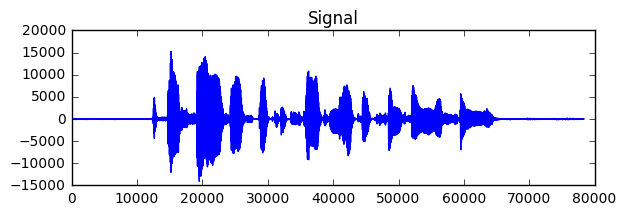

In [5]:
fs, s_clean = load_wav('../data/chime/clean/F01_22GC010A_BTH.CH1.wav')

plt.figure(figsize=(6.75,2))
plt.plot(s_clean)
plt.title('Signal')
plt.show()

wavPlayer(s_clean, fs)

In [6]:
f_clean, t_clean, Sxx_clean = scipy.signal.spectrogram(s_clean, fs=16000, nfft=1024)

### Noisy

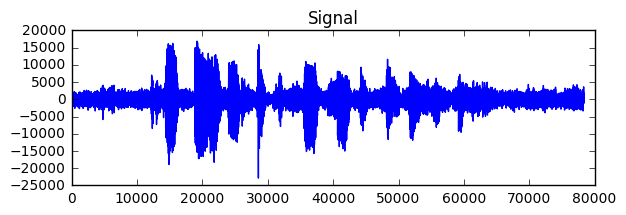

In [7]:
fs, s_noisy = load_wav('../data/chime/noisy/caf_simu/F01_22GC010A_CAF.CH1.wav')

plt.figure(figsize=(6.75,2))
plt.plot(s_noisy)
plt.title('Signal')
plt.show()

wavPlayer(s_noisy, fs)

In [8]:
f_noisy, t_noisy, Sxx_noisy = scipy.signal.spectrogram(s_noisy, fs=16000, nfft=1024)

### Background

In [9]:
fs, s_back = load_wav('../data/chime/backgrounds/BGD_150203_010_CAF.CH1.wav')

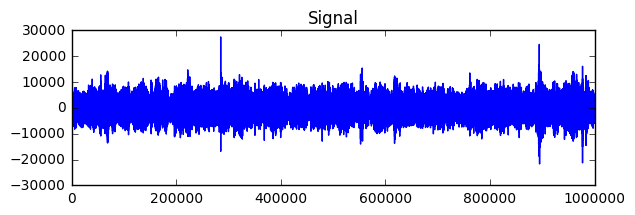

In [13]:
s_back_trunc = s_back[:1000000]

plt.figure(figsize=(6.75,2))
plt.plot(s_back_trunc)
plt.title('Signal')
plt.show()

wavPlayer(s_back_trunc, fs)

In [14]:
f_back, t_back, Sxx_back = scipy.signal.spectrogram(s_back_trunc, fs=16000, nfft=1024)

In [16]:
Sxx_back.shape

(513, 4464)

# AAAAAAAAAA

In [ ]:
f_noisy, t_noisy, Sxx_noisy = scipy.signal.spectrogram(s_noisy, fs=16000, nfft=1024)

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.pcolormesh(t_clean, f_clean[:150] / (len(s_noisy) * 1. / fs), Sxx_clean[:150], cmap="Greys", vmax=40000)
plt.title("Clean")
plt.subplot(122)
plt.pcolormesh(t_noisy, f_noisy[:150] / (len(s_noisy) * 1. / fs), Sxx_noisy[:150], cmap="Greys", vmax=40000)
plt.title("Noisy")

In [ ]:
W, H = factorization(Sxx_noisy)

In [ ]:
np.array(W.dot(H)).shape

In [ ]:
f_factor, t_factor, Sxx_factor = f_noisy, t_noisy, np.array(W.dot(H))

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.pcolormesh(t_noisy, f_noisy[:150] / (len(s_noisy) * 1. / fs), Sxx_noisy[:150], cmap="Greys", vmax=40000)
plt.title("Noisy")
plt.subplot(122)
plt.pcolormesh(t_factor, f_factor[:150] / (len(s_noisy) * 1. / fs), Sxx_factor[:150], cmap="Greys", vmax=40000)
plt.title("Factorized")

In [ ]:
W, H = factorization(Sxx_clean)

In [ ]:
note = 1
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(f_clean / (len(s_clean) * 1. / fs), W.T[note])
plt.title("W")
plt.subplot(122)
plt.plot(t_clean, H[note])
plt.title("H")

In [ ]:
plt.pcolormesh(t_clean, f_clean[:150] / (len(s_clean) * 1. / fs), Sxx_clean[:150], cmap="Greys", vmax=40000)
main_freq = (f_clean[:150] / (len(s_clean) * 1. / fs))[np.argmax(W.T[note])]
plt.plot([0, 5], [main_freq, main_freq], "r")
plt.xlim([0, 5])
plt.title("Clean")